### Import libraries

In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
import shap
# from captum.attr import IntegratedGradients, ShapleyValueSampling
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
import math
import itertools

from libs.models import *

plt.rcParams.update({'font.size': 12, 'figure.figsize': (10, 4), 'figure.dpi': 300})

# Import data

In [3]:
# read data
df = pd.read_csv('data/data.csv')

# Prepare data for training

In [4]:
# prepare expanding window splits
periods = {
    '21' : '2020-01-01', # 2021 is the test set
    # '22' : '2021-01-01', # 2022 is the test set
    # '23' : '2022-01-01', # 2023 is the test set
    # '24': '2023-01-01' # 2024 is the test set
}

# identify dummy vs. numeric columns
feature_cols = [col for col in df.columns if col not in ['timestamp', 'ticker', 'target']]
nace_cols = [c for c in feature_cols if c.startswith('NACE_')]
dummy_cols = ['divi','divo'] # sin removed
macro_cols = ['discount', 'tms', 'dp', 'ep', 'svar'] # 'bm_macro'

# nummeric cols = cols not in cat and macro cols
numeric_cols = [c for c in feature_cols if c not in dummy_cols and c not in nace_cols and c not in macro_cols]

# feature_cols = numeric_cols + dummy_cols + nace_cols # reorder columns to have numeric first

df_raw = df.copy(deep=True)
df_raw['timestamp'] = pd.to_datetime(df_raw['timestamp'])

# drop data from 2025
df_raw = df_raw[df_raw['timestamp'] < '2025-01-01']

In [5]:
# create interaction features between numeric and macro features
C = df[numeric_cols].values         # shape = (n_rows, P_c)
X = df[macro_cols].values           # shape = (n_rows, P_x)

# compute all pairwise products with broadcasting:
K = C[:,:,None] * X[:,None,:]

# reshape to (n_rows, P_c * P_x)
Z = K.reshape(len(df), -1)

# build the column names in the same order
xc_names = [
    f"{c}_x_{m}"
    for c in numeric_cols
    for m in macro_cols
]

# wrap back into a DataFrame
df_xc = pd.DataFrame(Z, columns=xc_names, index=df.index)

feature_cols = numeric_cols + xc_names + dummy_cols + nace_cols
numeric_cols = numeric_cols + xc_names
cat_cols = dummy_cols + nace_cols
df_z = df_raw.merge(df_xc, left_index=True, right_index=True)
# drop macro_cols
df_z = df_z.drop(columns=macro_cols)
# sort columns by feature_cols
df_norm = df_z[['timestamp', 'ticker', 'target'] + feature_cols]

y_values = df_norm['target'].values.astype('float32')


In [6]:
# prepare containers
X_train, X_val, X_test = {}, {}, {}
y_train, y_val, y_test = {}, {}, {}
preprocessors = {}

for y, period in periods.items():
    period = pd.to_datetime(period)

    # split masks
    tr_mask = df_norm['timestamp'] < period
    va_mask = (df_norm['timestamp'] >= period) & \
              (df_norm['timestamp'] - pd.DateOffset(years=1) < period)
    te_mask = (df_norm['timestamp'] - pd.DateOffset(years=1) >= period) & \
              (df_norm['timestamp'] - pd.DateOffset(years=2) < period)

    # extract raw feature DataFrames
    X_tr_df = df_norm.loc[tr_mask, feature_cols].copy()
    X_va_df = df_norm.loc[va_mask, feature_cols].copy()
    X_te_df = df_norm.loc[te_mask, feature_cols].copy()
    y_tr    = y_values[tr_mask]
    y_va    = y_values[va_mask]
    y_te    = y_values[te_mask]

    # compute winsorization bounds on train
    lower = X_tr_df[numeric_cols].quantile(0.01)
    upper = X_tr_df[numeric_cols].quantile(0.99)

    # apply clipping to train, val, test
    X_tr_df[numeric_cols] = X_tr_df[numeric_cols].clip(lower=lower, upper=upper, axis=1)
    X_va_df[numeric_cols] = X_va_df[numeric_cols].clip(lower=lower, upper=upper, axis=1)
    X_te_df[numeric_cols] = X_te_df[numeric_cols].clip(lower=lower, upper=upper, axis=1)


    # now fit scaler on numeric only
    preprocessor = ColumnTransformer([
        ('num', StandardScaler(), numeric_cols),
        ('cat', 'passthrough',  cat_cols)
    ])
    preprocessor.fit(X_tr_df)
    preprocessors[y] = preprocessor

    # transform all splits
    X_train[y] = preprocessor.transform(X_tr_df).astype('float32')
    X_val[y]   = preprocessor.transform(X_va_df).astype('float32')
    X_test[y]  = preprocessor.transform(X_te_df).astype('float32')

    # store targets as before
    y_train[y] = y_tr.reshape(-1, 1)
    y_val[y]   = y_va.reshape(-1, 1)
    y_test[y]  = y_te.reshape(-1, 1)


In [7]:
# moving to metal or CUDA GPU if available
device = torch.device(("cuda" if torch.cuda.is_available() 
                       else "mps" if torch.backends.mps.is_available() 
                       else "cpu"))
print("Using device:", device)

# general hyperparameters
hidden_depth = None 
hidden_width = None 
learning_rate = 1e-4 
activation_fun = nn.ReLU # nn.ReLU, nn.Tanh, nn.Sigmoid, nn.LeakyReLU

# general critereon and regularization parameters
criterion = nn.MSELoss()
lambda_l1 = 1e-4 # baseline l1 regularization
lambda_l2 = 1e-4 # baseline l2 regularization
drop = 0.0

# general parmeters
patience = 25
print_freq = 100
epochs = 250
batch_size = 4096 


Using device: mps


# Test hyperparameters

## Constant scheme

In [9]:
year = '21'
n_runs = 5

In [ ]:
# training model with most data on multiple parameters
l1_space = [lambda_l1]
l2_space = [lambda_l2]
dropout_space = [drop]
learning_rate_space = [learning_rate]
depth_space = [1, 2, 3, 4, 5, 6, 7]
width_space = [8, 16, 32, 64, 128]

In [ ]:
# current runtime: 2h 35m
best_models_size = {}
history_size = {}
models_21 = {}

for lambda_l1 in l1_space:
    for lambda_l2 in l2_space:
        for dropout in dropout_space:
            for learning_rate in learning_rate_space:
                for hidden_depth in depth_space:
                    for hidden_width in width_space:
                        print(f"""Training model for year '{year}...: 
                                lambda_l1       ={lambda_l1:.0e}
                                lambda_l2       ={lambda_l2:.0e}
                                dropout         ={dropout:.0e}
                                learning_rate   ={learning_rate:.0e}
                                hidden_depth    ={hidden_depth}
                                hidden_width    ={hidden_width}""")
                        for run in range(n_runs):
                            print(f"Run {run+1} of {n_runs}")
                            seed = 42+run   
                            np.random.seed(seed)
                            torch.manual_seed(seed)
                            # Initialize the model
                            input_dim = X_train[year].shape[1]
                            name = f'l1{lambda_l1}_l2{lambda_l2}_drop{dropout}_lr{learning_rate}_w{hidden_width}_d{hidden_depth}_run{run+1}'
                            models_21[name] = MLPModel(input_dim, depth=hidden_depth, width=hidden_width, dropout=dropout, activation=activation_fun).to(device)
                            optimizer = torch.optim.Adam(models_21[name].parameters(), lr=learning_rate)
                            train = MLPdataset(X_train[year], y_train[year])
                            val = MLPdataset(X_val[year], y_val[year])
                            best_models_size[name], history_size[name] = train_mlp(train,          
                                                            val,
                                                            models_21[name],
                                                            criterion,
                                                            epochs,
                                                            patience,
                                                            print_freq,
                                                            device,
                                                            optimizer,
                                                            lambda_l1=lambda_l1,
                                                            lambda_l2=lambda_l2,
                                                            batch_size=batch_size,
                                                            shuffle_train=True,
                                                            shuffle_val=False,
                                                            save_path=f'models/hyperparam_test/mlp_y{year}_l1{lambda_l1}_l2{lambda_l2}_drop{dropout}_lr{learning_rate}_w{hidden_width}_d{hidden_depth}_run{run+1}.pth'
                                                            )

Training model for year '21...: 
                                lambda_l1       =1e-04
                                lambda_l2       =1e-04
                                dropout         =0e+00
                                learning_rate   =1e-04
                                hidden_depth    =1
                                hidden_width    =8
Run 1 of 5
Epoch 100/250  - Train Loss: 2.43394E-02  - Val Loss: 2.07440E-02
Epoch 200/250  - Train Loss: 2.37068E-02  - Val Loss: 2.03020E-02
Early stopping at epoch 225
Best val loss: 2.03020E-02
Model saved to models/hyperparam_test/mlp_y21_l10.0001_l20.0001_drop0.0_lr0.0001_w8_d1_run1.pth
Run 2 of 5
Epoch 100/250  - Train Loss: 2.48385E-02  - Val Loss: 2.01433E-02
Epoch 200/250  - Train Loss: 2.41557E-02  - Val Loss: 1.99527E-02
Early stopping at epoch 201
Best val loss: 1.99398E-02
Model saved to models/hyperparam_test/mlp_y21_l10.0001_l20.0001_drop0.0_lr0.0001_w8_d1_run2.pth
Run 3 of 5
Epoch 100/250  - Train Loss: 2.48113E-02  - Va

## Pyramid scheme

In [ ]:
# training model with most data on multiple parameters
l1_space = [lambda_l1]
l2_space = [lambda_l2]
dropout_space = [drop]
learning_rate_space = [learning_rate]
depth_space = None
width_space = [[32], 
               [32, 16], 
               [32, 16, 8], 
               [32, 16, 8, 4], 
               [32, 16, 8, 4, 2]]

In [80]:
best_models_pyramid = {}
history_pyramid = {}
for lambda_l1 in l1_space:
    for lambda_l2 in l2_space:
        for dropout in dropout_space:
            for learning_rate in learning_rate_space:
                for hidden_width in width_space:
                    hidden_depth = len(hidden_width)
                    print(f"""Training model for year '{year}...: 
                            lambda_l1       ={lambda_l1:.0e}
                            lambda_l2       ={lambda_l2:.0e}
                            dropout         ={dropout:.0e}
                            learning_rate   ={learning_rate:.0e}
                            hidden_depth    ={hidden_depth}
                            hidden_width    ={hidden_width}""")
                    for run in range(n_runs):
                        print(f"Run {run+1} of {n_runs}")
                        seed = 42+run
                        np.random.seed(seed)
                        torch.manual_seed(seed)
                        # Initialize the model
                        input_dim = X_train[year].shape[1]
                        name = f'l1{lambda_l1}_l2{lambda_l2}_drop{dropout}_lr{learning_rate}_w{hidden_width}_d{hidden_depth}_run{run+1}'
                        models_21[name] = MLPModel(input_dim, depth=hidden_depth, width=hidden_width, dropout=dropout, activation=activation_fun).to(device)
                        optimizer = torch.optim.Adam(models_21[name].parameters(), lr=learning_rate)
                        train = MLPdataset(X_train[year], y_train[year])
                        val = MLPdataset(X_val[year], y_val[year])
                        best_models_pyramid[name], history_pyramid[name] = train_mlp(train,          
                                                        val,
                                                        models_21[name],
                                                        criterion,
                                                        epochs,
                                                        patience,
                                                        print_freq,
                                                        device,
                                                        optimizer,
                                                        lambda_l1=lambda_l1,
                                                        lambda_l2=lambda_l2,
                                                        batch_size=batch_size,
                                                        shuffle_train=True,
                                                        shuffle_val=False,
                                                        save_path=f'models/hyperparam_test/mlp_y{year}_l1{lambda_l1}_l2{lambda_l2}_drop{dropout}_lr{learning_rate}_w{hidden_width}_d{hidden_depth}_run{run+1}.pth'
                                                        )

Training model for year '21...: 
                            lambda_l1       =1e-04
                            lambda_l2       =1e-04
                            dropout         =0e+00
                            learning_rate   =1e-04
                            hidden_depth    =1
                            hidden_width    =[32]
Run 1 of 5
Epoch 100/250  - Train Loss: 2.30012E-02  - Val Loss: 2.05463E-02
Early stopping at epoch 125
Best val loss: 2.05463E-02
Model saved to models/hyperparam_test/mlp_y21_l10.0001_l20.0001_drop0.0_lr0.0001_w[32]_d1_run1.pth
Run 2 of 5
Epoch 100/250  - Train Loss: 2.35545E-02  - Val Loss: 2.25159E-02
Early stopping at epoch 132
Best val loss: 2.24409E-02
Model saved to models/hyperparam_test/mlp_y21_l10.0001_l20.0001_drop0.0_lr0.0001_w[32]_d1_run2.pth
Run 3 of 5
Epoch 100/250  - Train Loss: 2.33057E-02  - Val Loss: 2.17520E-02
Early stopping at epoch 164
Best val loss: 2.16428E-02
Model saved to models/hyperparam_test/mlp_y21_l10.0001_l20.0001_drop0.0_

## Depth and width comparison

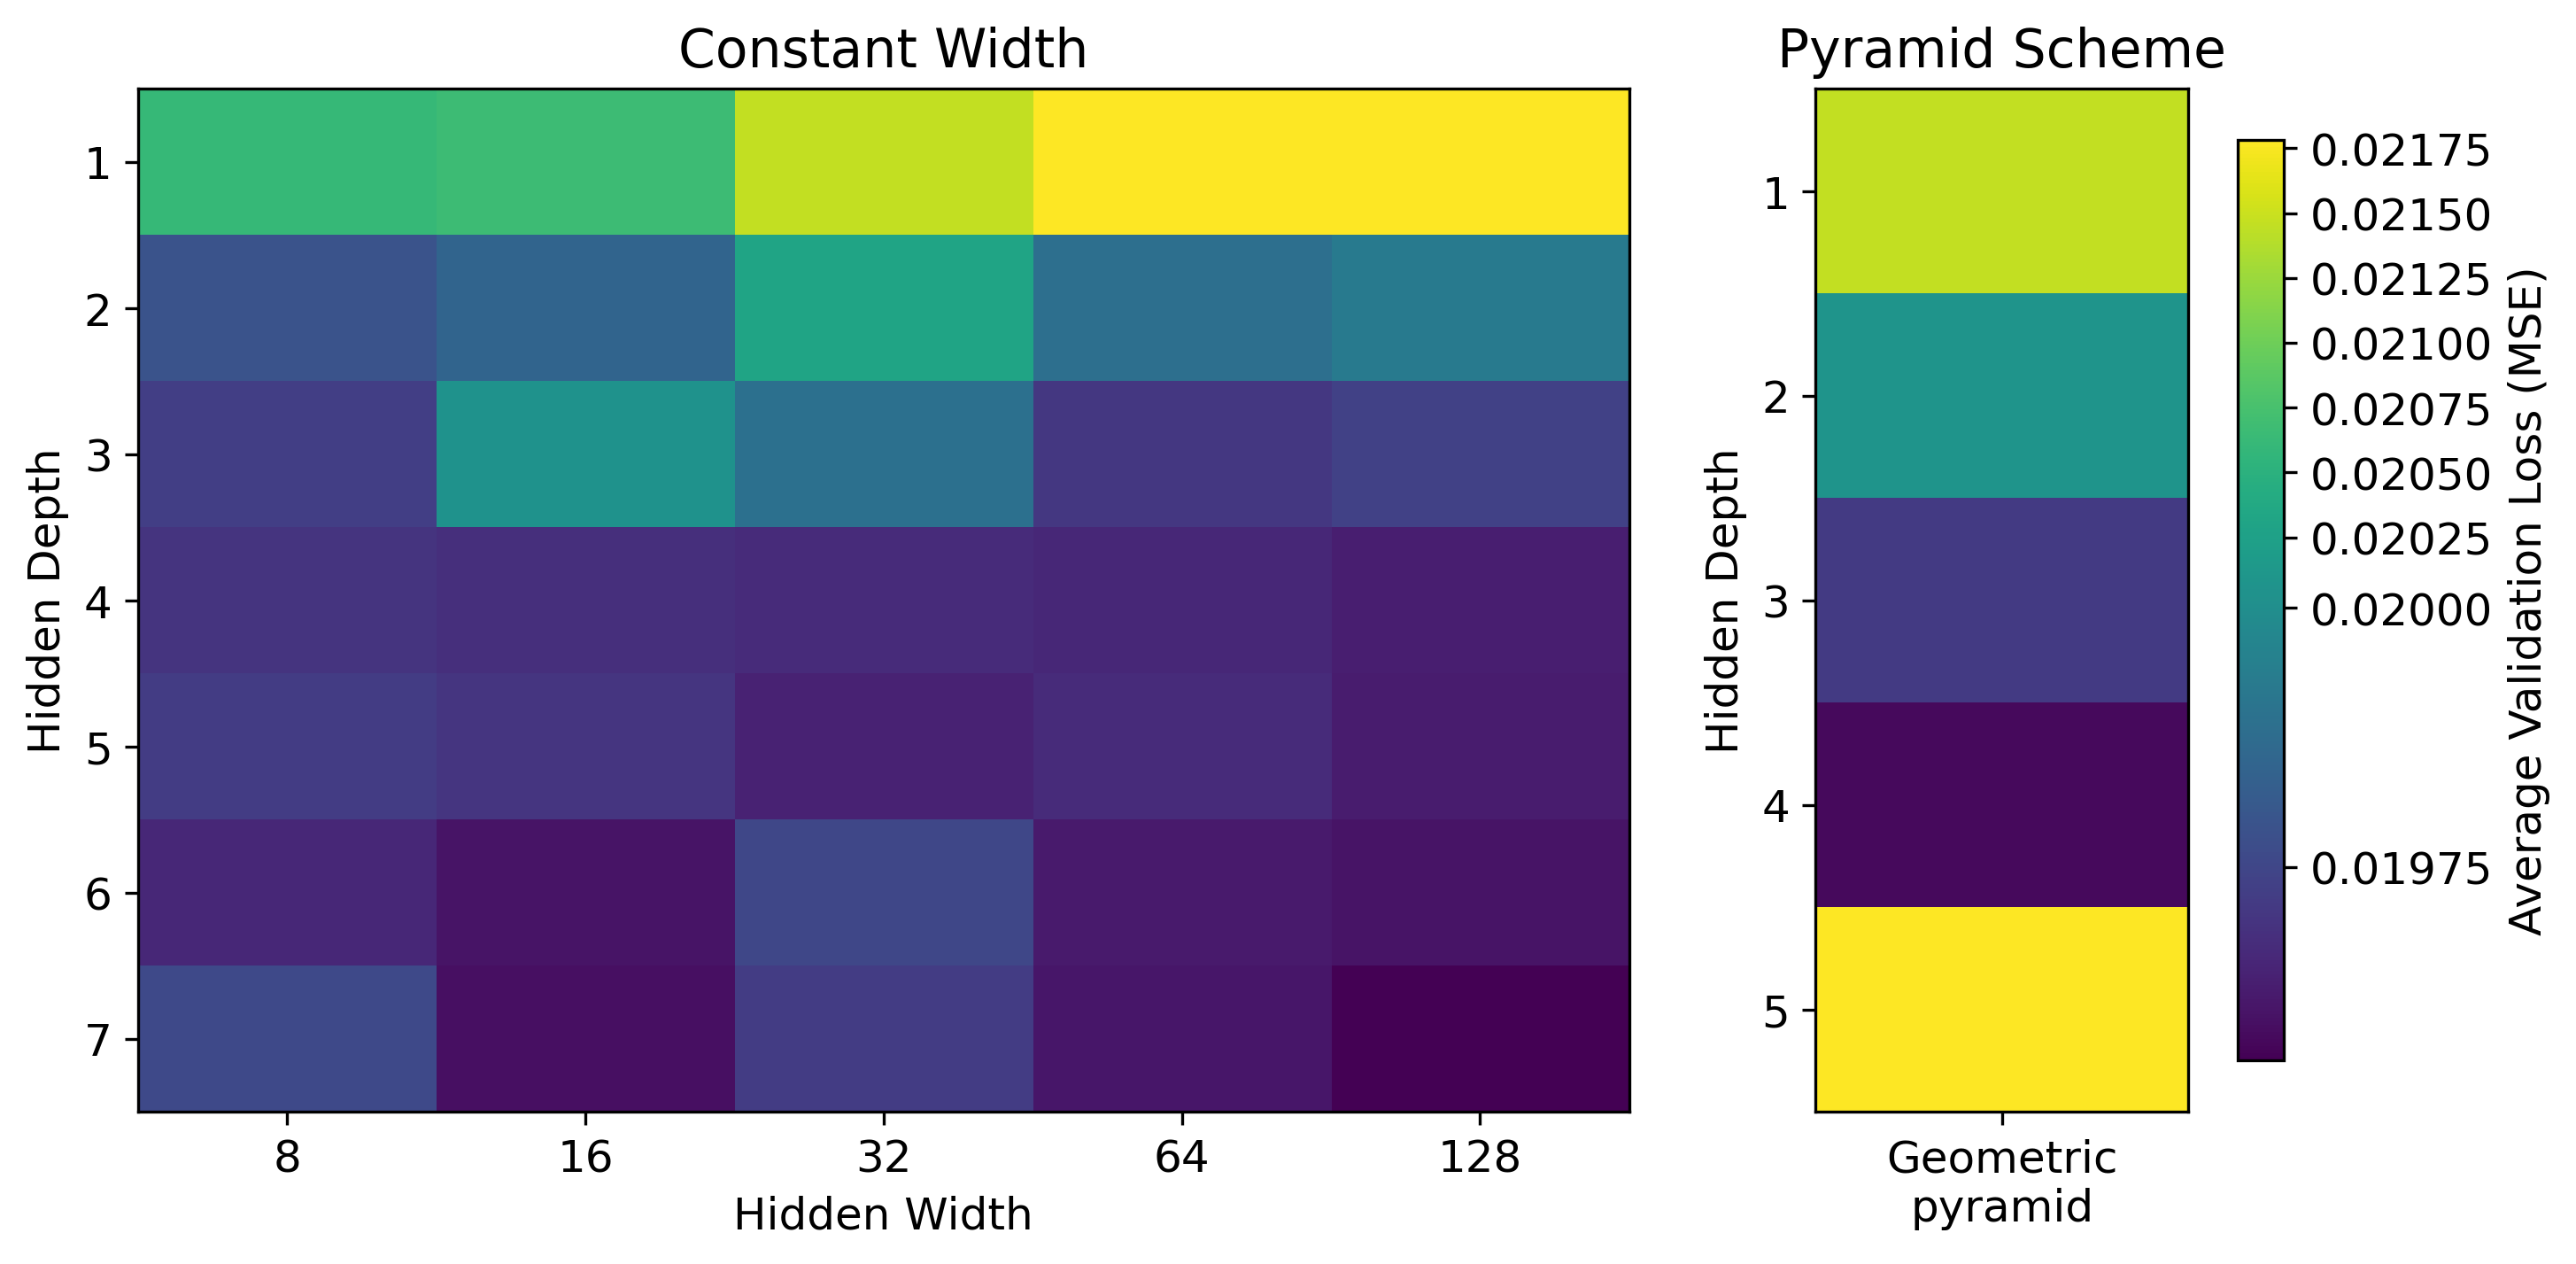

In [22]:
# constant-width grid
const_widths = [8, 16, 32, 64, 128]
const_depths = [1, 2, 3, 4, 5, 6, 7]

# pyramid sequences (each column of the right heatmap)
pyr_seqs = [
    [32],
    [32,16],
    [32,16,8],
    [32,16,8,4],
    [32,16,8,4,2],
]
Wc = len(const_widths)
Dc = len(const_depths)
Wp = len(pyr_seqs)

# model loader fun
def load_model(width, depth, run):
    m = MLPModel(
        input_dim  = X_train[year].shape[1],
        depth      = depth,
        width      = width,
        dropout    = drop,
        activation = activation_fun,
    ).to(device)
    path = (
        f"models/hyperparam_test/mlp_y{year}"
        f"_l1{lambda_l1}_l2{lambda_l2}"
        f"_drop{drop}_lr{learning_rate}"
        f"_w{width}_d{depth}_run{run+1}.pth"
    )
    m.load_state_dict(torch.load(path, map_location=device))
    m.eval()
    return m

# DataLoader
val_ds     = MLPdataset(X_val[year], y_val[year])
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

# constant-width loss matrix
loss_const = np.zeros((Dc, Wc))
for di, d in enumerate(const_depths):
    for wj, w in enumerate(const_widths):
        run_losses = []
        for run in range(n_runs):
            m = load_model(w, d, run)
            with torch.no_grad():
                batch = [criterion(m(x.to(device)), y.to(device)).item()
                         for x,y in val_loader]
            run_losses.append(np.mean(batch))
        loss_const[di, wj] = np.mean(run_losses)

# pyramid loss matrix
loss_pyr = np.full((Wp, Wp), np.nan)
for sj, seq in enumerate(pyr_seqs):
    depth = len(seq)
    run_losses = []
    for run in range(n_runs):
        # we “flatten” seq into width param for loader
        m = load_model(seq, depth, run)
        with torch.no_grad():
            batch = [criterion(m(x.to(device)), y.to(device)).item()
                     for x,y in val_loader]
        run_losses.append(np.mean(batch))
    loss_pyr[depth-1, sj] = np.mean(run_losses)

# plot
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12,5),
                               gridspec_kw={'width_ratios':[4,1]})

# color‐scale
all_vals = np.concatenate([loss_const.ravel(),
                           loss_pyr[np.isfinite(loss_pyr)]])
all_vals = loss_const.ravel()
vmin    = all_vals.min()
vmax    = all_vals.max()
vcenter = vmin + 0.2*(vmax - vmin)
norm    = TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)
cmap    = 'viridis'

# left: constant‐width heatmap
im0 = ax0.imshow(loss_const, aspect='auto', cmap=cmap, norm=norm)
im0 = ax0.imshow(loss_const, aspect='auto', cmap=cmap, norm=norm)
ax0.set_xticks(range(Wc))
ax0.set_xticklabels(const_widths)
ax0.set_yticks(range(Dc))
ax0.set_yticklabels(const_depths)
ax0.set_xlabel('Hidden Width')
ax0.set_ylabel('Hidden Depth')
ax0.set_title(f'Constant Width')

# right: collapsed‐x pyramid heatmap
diag_pyr = np.diag(loss_pyr)
diag_mat = diag_pyr[:, np.newaxis]

im1 = ax1.imshow(diag_mat, aspect='auto', cmap=cmap, norm=norm)
ax1.set_xticks([0])
ax1.set_xticklabels(['Geometric\npyramid'])
ax1.set_yticks(np.arange(Wp))
ax1.set_yticklabels(np.arange(1, Wp+1))
ax1.set_ylabel('Hidden Depth')
ax1.set_title('Pyramid Scheme')

# shared colorbar
cbar = fig.colorbar(im0, ax=[ax0,ax1], shrink=0.9, pad=0.02)
cbar.set_label('Average Validation Loss (MSE)')

# plt.tight_layout()
plt.savefig('figs/width_depth.png', dpi=300, bbox_inches='tight')
plt.show()



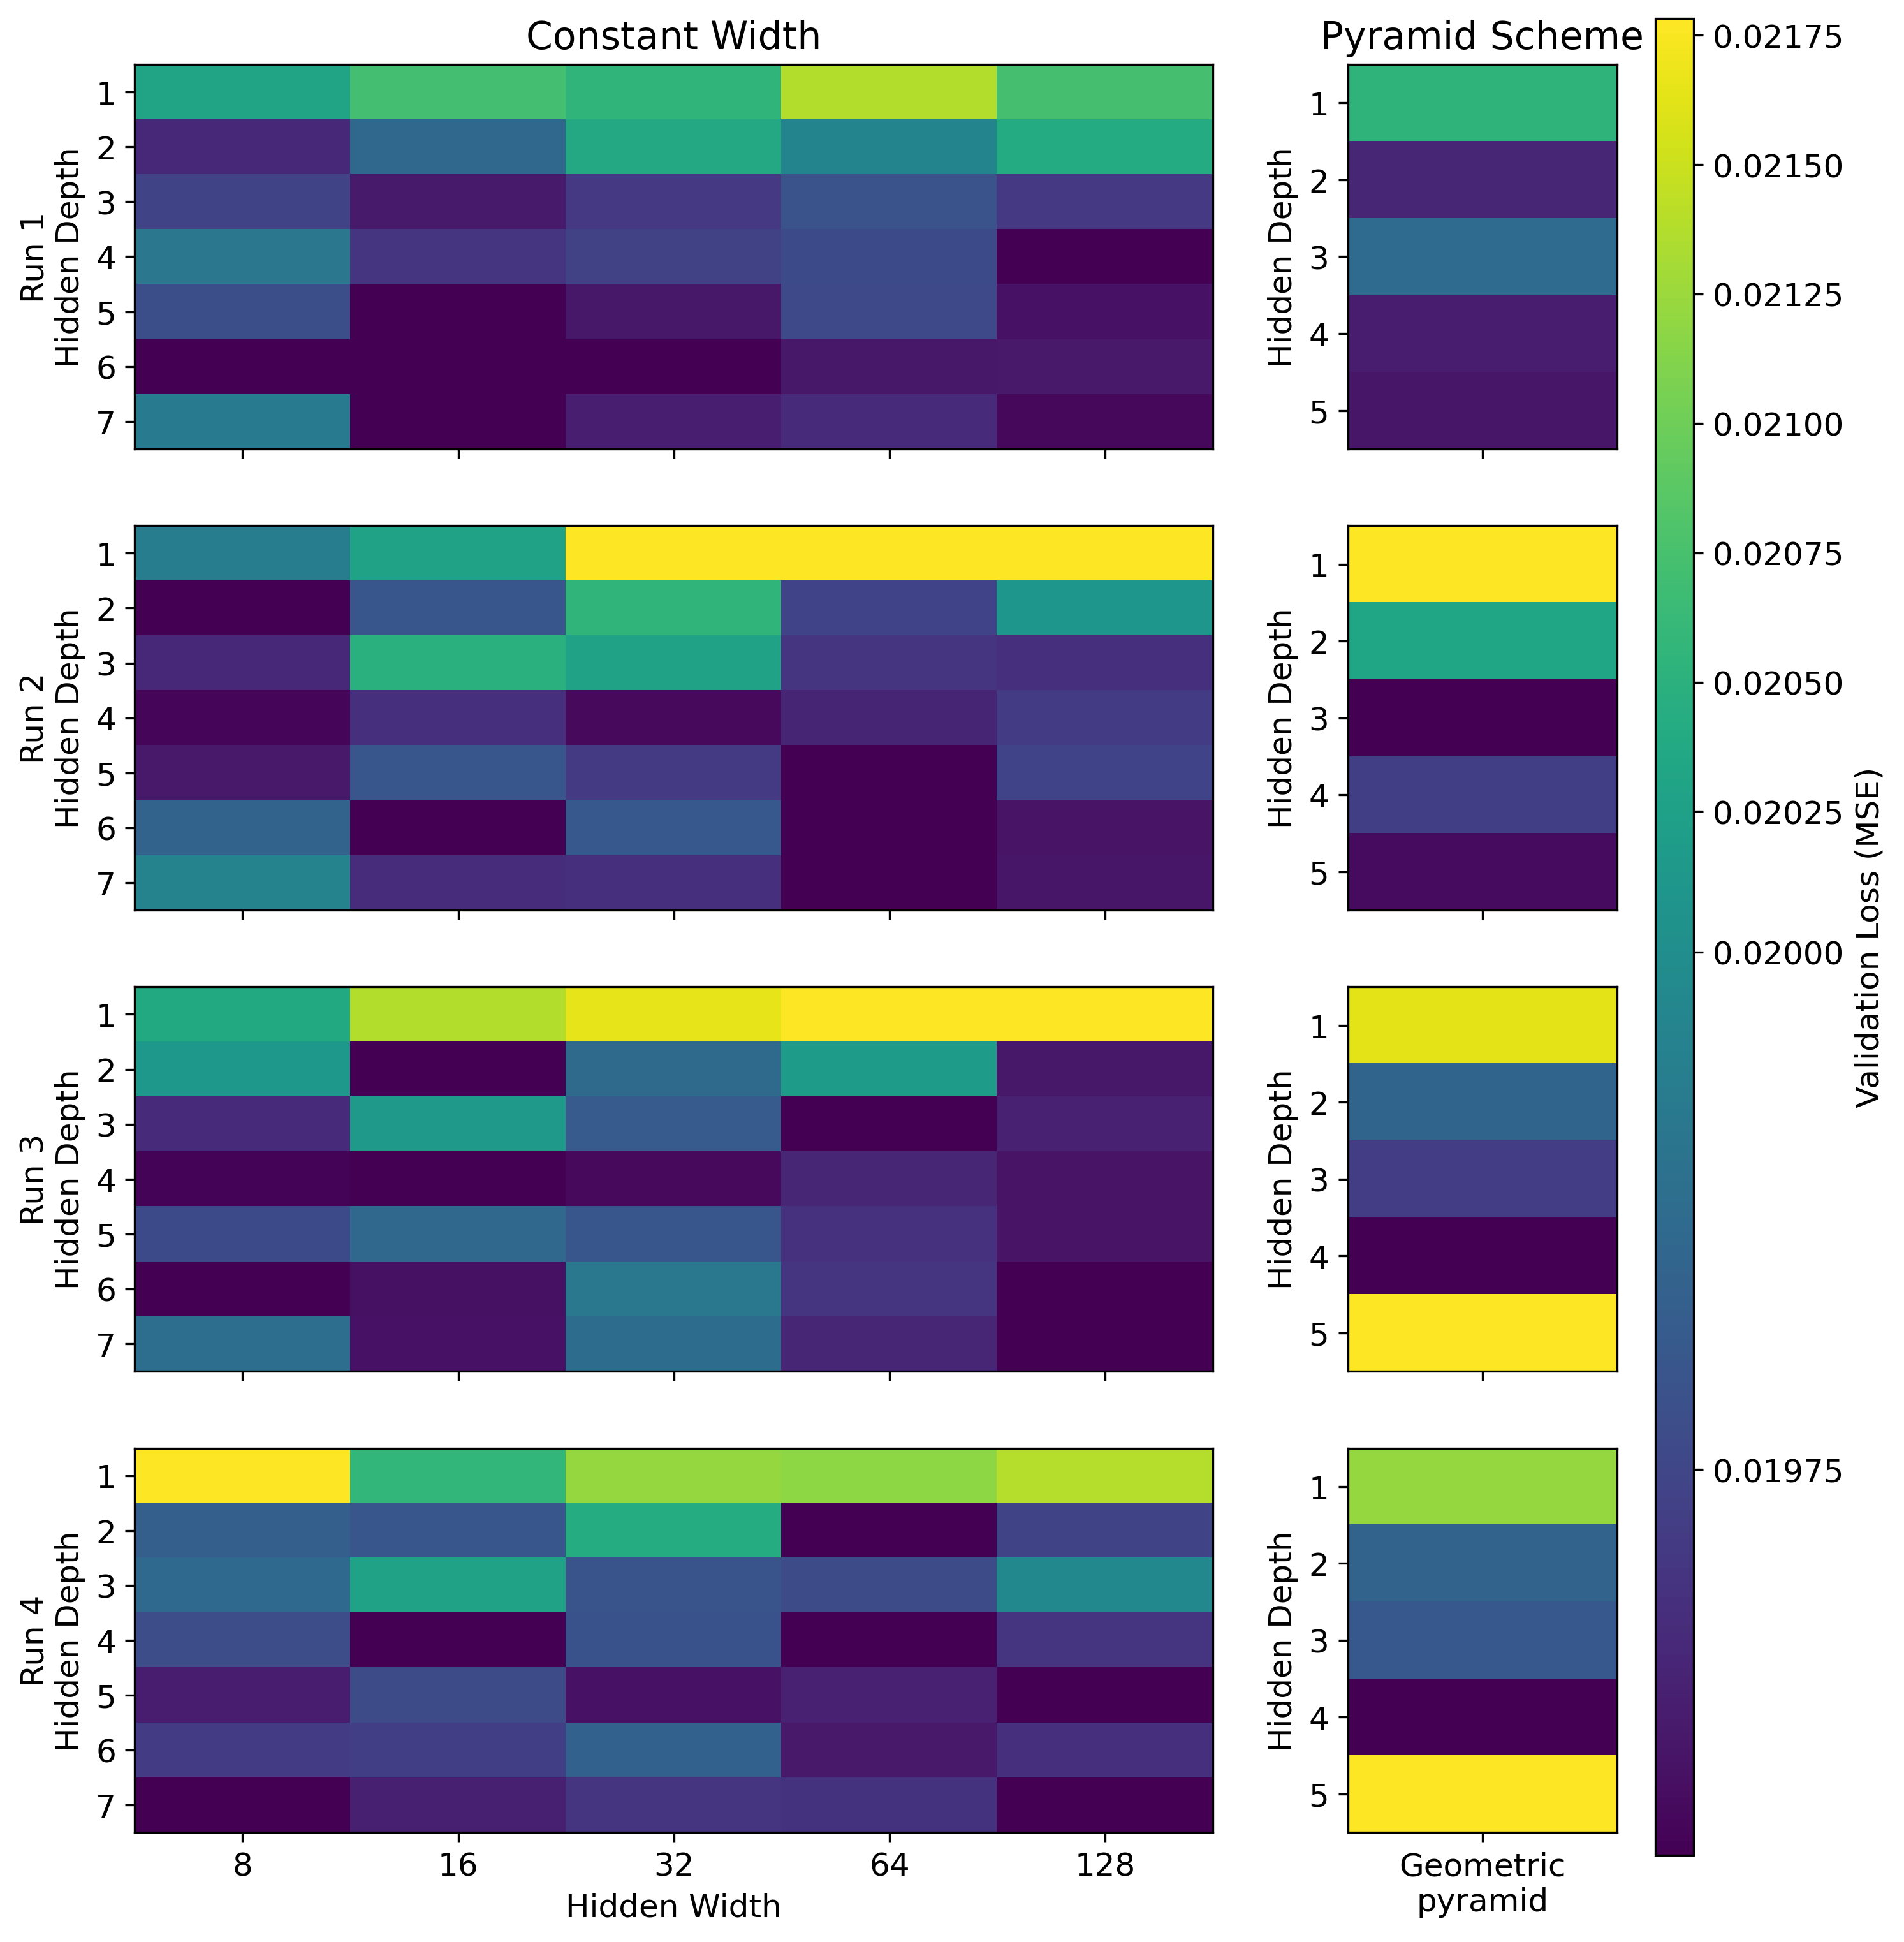

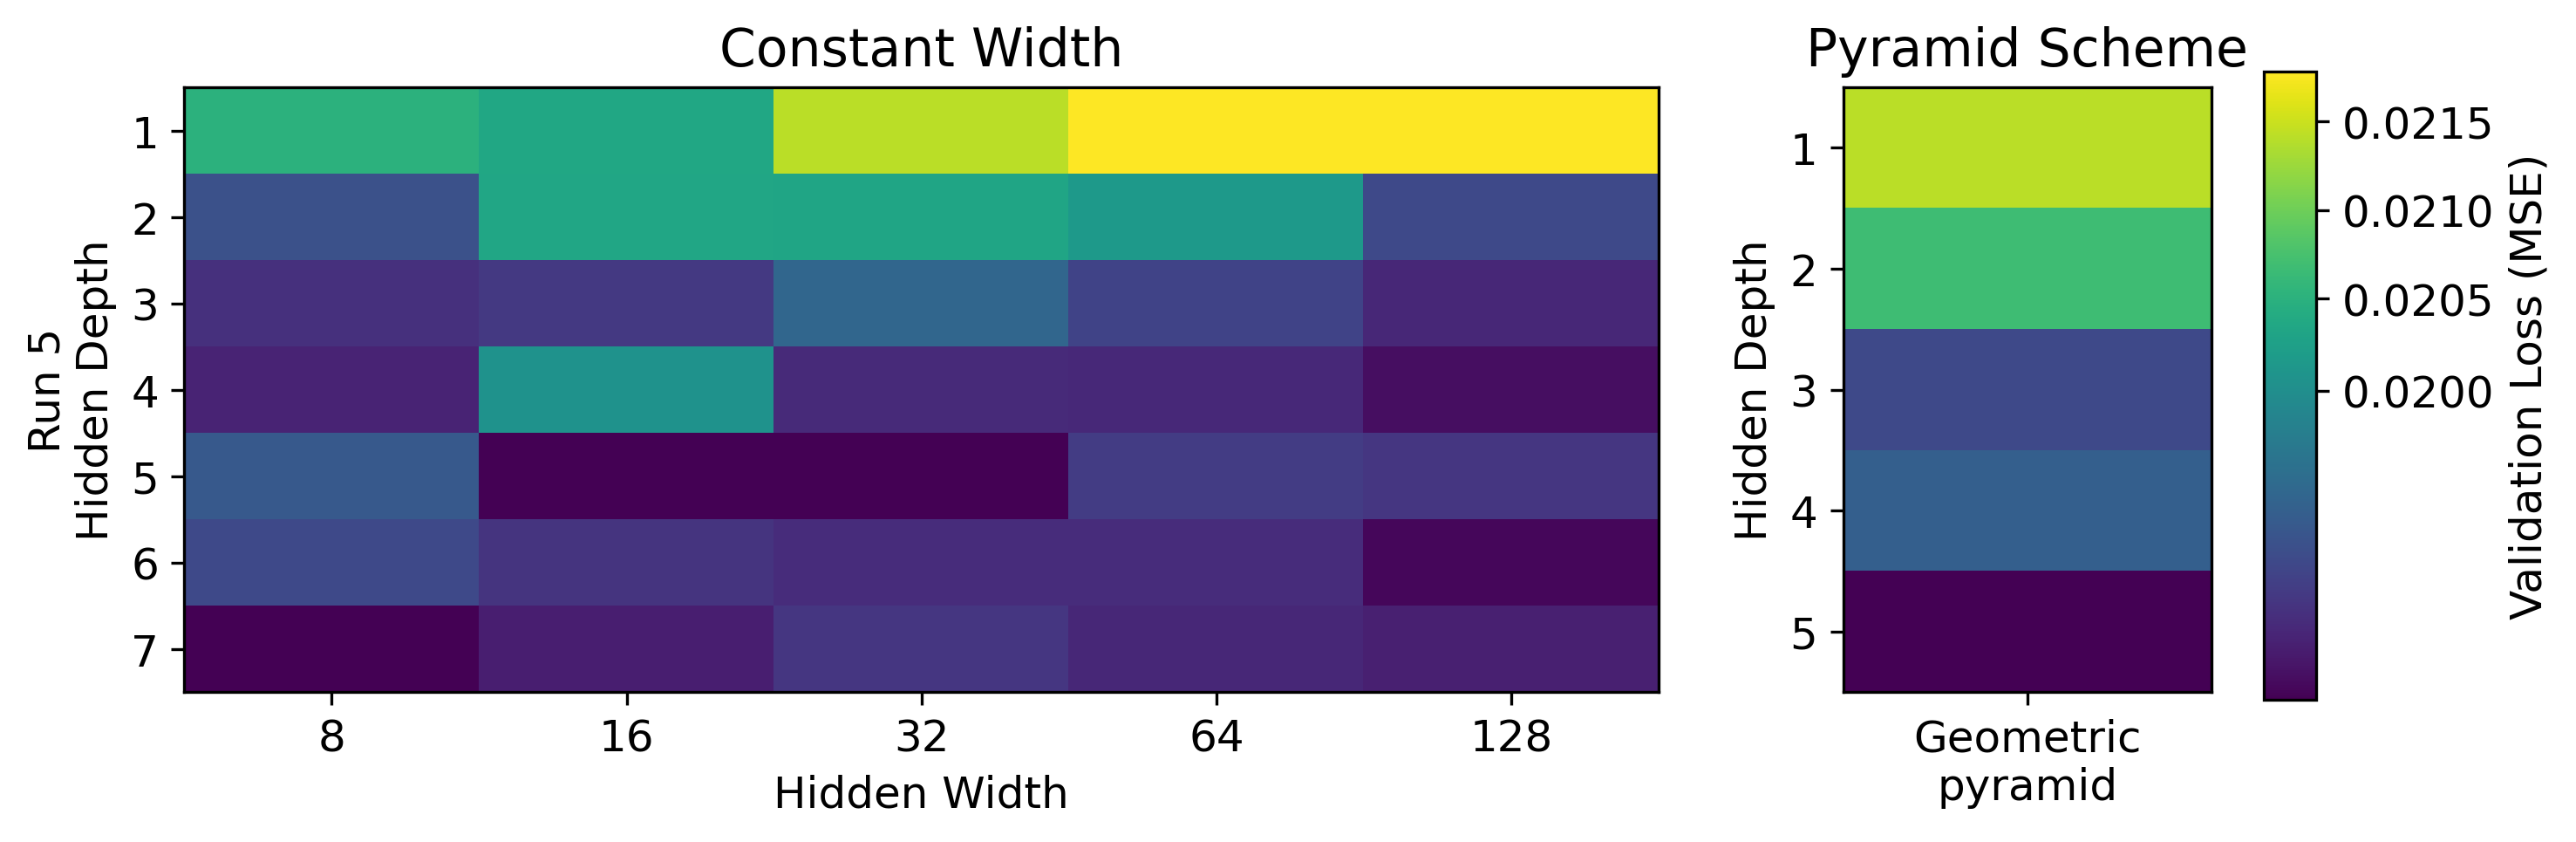

In [33]:
# pre‐compute global vmin/vmax across all runs so color‐scale is consistent
all_vals = []
for run in range(n_runs):
    # constant‐width for this run
    tmp = []
    for d in const_depths:
        for w in const_widths:
            m = load_model(w, d, run)
            with torch.no_grad():
                batch = [criterion(m(x.to(device)), y.to(device)).item()
                         for x,y in val_loader]
            tmp.append(np.mean(batch))
    all_vals.extend(tmp)

    # pyramid diag for this run
    diag = []
    for seq in pyr_seqs:
        depth = len(seq)
        m = load_model(seq, depth, run)
        with torch.no_grad():
            batch = [criterion(m(x.to(device)), y.to(device)).item()
                     for x,y in val_loader]
        diag.append(np.mean(batch))
    all_vals.extend(diag)

runs = list(range(n_runs))
# split into pages of 4 runs each
pages = [runs[i:i+4] for i in range(0, len(runs), 4)]

for p, page_runs in enumerate(pages, start=1):
    nrows = len(page_runs)
    fig, axes = plt.subplots(
        nrows, 2,
        figsize=(10, 3*nrows),
        gridspec_kw={'width_ratios': [4, 1]},
        constrained_layout=False  # turn off for manual colorbar placement
    )

    # if only one row, wrap axes
    if nrows == 1:
        axes = np.expand_dims(axes, 0)

    for i, run in enumerate(page_runs):
        ax0, ax1 = axes[i]

        # ---- left: constant-width heatmap for this run ----
        loss_const = np.zeros((Dc, Wc))
        for di, d in enumerate(const_depths):
            for wj, w in enumerate(const_widths):
                m = load_model(w, d, run)
                with torch.no_grad():
                    batch = [criterion(m(x.to(device)), y.to(device)).item()
                             for x,y in val_loader]
                loss_const[di, wj] = np.mean(batch)

        im0 = ax0.imshow(loss_const, aspect='auto', cmap=cmap, norm=norm)
        if i == 0:
            ax0.set_title('Constant Width')
        ax0.set_ylabel(f'Run {run+1}\nHidden Depth')
        ax0.set_xticks(range(Wc))
        ax0.set_xticklabels(const_widths)
        ax0.set_yticks(range(Dc))
        ax0.set_yticklabels(const_depths)
        if i == nrows - 1:
            ax0.set_xlabel('Hidden Width')
        else:
            ax0.set_xlabel('')
            ax0.tick_params(labelbottom=False)

        # ---- right: collapsed pyramid for this run ----
        diag = []
        for seq in pyr_seqs:
            depth = len(seq)
            m = load_model(seq, depth, run)
            with torch.no_grad():
                batch = [criterion(m(x.to(device)), y.to(device)).item()
                         for x,y in val_loader]
            diag.append(np.mean(batch))
        diag_mat = np.array(diag)[:, None]

        im1 = ax1.imshow(diag_mat, aspect='auto', cmap=cmap, norm=norm)
        if i == 0:
            ax1.set_title('Pyramid Scheme')
        ax1.set_xticks([0])
        # only label the bottom subplot
        if i == nrows - 1:
            ax1.set_xticklabels(['Geometric\npyramid'])
        else:
            ax1.set_xticklabels([])
        ax1.set_yticks(range(Wp))
        ax1.set_yticklabels(range(1, Wp+1))
        ax1.set_ylabel('Hidden Depth')

    # shared colorbar on the right of this page
    cax = fig.add_axes([0.92,  # 92% from left
                        0.10,  # 10% from bottom
                        0.02,  # 2% figure‐width
                        0.80   # 80% figure‐height
                       ])
    cbar = fig.colorbar(im0, cax=cax)
    cbar.set_label('Validation Loss (MSE)')

    fig.savefig(f'figs/width_depth_page{p}.png', dpi=300, bbox_inches='tight')
    plt.show()


## Regularization strength

In [81]:
# training model with most data on multiple parameters
l1_space = [0.0, 1e-4, 1e-3, 1e-2] # [0.0]
l2_space = [0.0, 1e-4, 1e-3, 1e-2] # [1e-4, 1e-3, 5e-3, 1e-2] # np.geomspace(1e-4, 1e-2, num=4)
dropout_space = [0.0, 0.1, 0.2, 0.3] # np.geomspace(0.0, 0.3, num=4)
learning_rate_space = [learning_rate] # np.geomspace(1e-4, 5e-3, num=4)
depth_space = [5] # [1, 2, 3]
width_space = [32] # [32, 64, 128]

In [82]:
best_models_reg = {}
history_reg = {}
for lambda_l1 in l1_space:
    for lambda_l2 in l2_space:
        for dropout in dropout_space:
            for learning_rate in learning_rate_space:
                for hidden_depth in depth_space:
                    for hidden_width in width_space:
                        np.random.seed(42)
                        torch.manual_seed(42)
                        print(f"""Training model for year '{year}...: 
                                lambda_l1       ={lambda_l1:.0e}
                                lambda_l2       ={lambda_l2:.0e}
                                dropout         ={dropout:.0e}
                                learning_rate   ={learning_rate:.0e}
                                hidden_depth    ={hidden_depth}
                                hidden_width    ={hidden_width}""")
                        # Initialize the model
                        input_dim = X_train[year].shape[1]
                        name = f'l1{lambda_l1}_l2{lambda_l2}_drop{dropout}_lr{learning_rate}_w{hidden_width}_d{hidden_depth}'
                        models_21[name] = MLPModel(input_dim, depth=hidden_depth, width=hidden_width, dropout=dropout, activation=activation_fun).to(device)
                        optimizer = torch.optim.Adam(models_21[name].parameters(), lr=learning_rate)
                        train = MLPdataset(X_train[year], y_train[year])
                        val = MLPdataset(X_val[year], y_val[year])
                        best_models_reg[name], history_reg[name] = train_mlp(train,          
                                                        val,
                                                        models_21[name],
                                                        criterion,
                                                        epochs,
                                                        patience,
                                                        print_freq,
                                                        device,
                                                        optimizer,
                                                        lambda_l1=lambda_l1,
                                                        lambda_l2=lambda_l2,
                                                        batch_size=batch_size,
                                                        shuffle_train=True,
                                                        shuffle_val=False,
                                                        save_path=f'models/hyperparam_test/mlp_y{year}_l1{lambda_l1}_l2{lambda_l2}_drop{dropout}_lr{learning_rate}_w{hidden_width}_d{hidden_depth}.pth'
                                                        )

Training model for year '21...: 
                                lambda_l1       =0e+00
                                lambda_l2       =0e+00
                                dropout         =0e+00
                                learning_rate   =1e-04
                                hidden_depth    =5
                                hidden_width    =32
Early stopping at epoch 77
Best val loss: 1.96319E-02
Model saved to models/hyperparam_test/mlp_y21_l10.0_l20.0_drop0.0_lr0.0001_w32_d5.pth
Training model for year '21...: 
                                lambda_l1       =0e+00
                                lambda_l2       =0e+00
                                dropout         =1e-01
                                learning_rate   =1e-04
                                hidden_depth    =5
                                hidden_width    =32
Early stopping at epoch 79
Best val loss: 1.97842E-02
Model saved to models/hyperparam_test/mlp_y21_l10.0_l20.0_drop0.1_lr0.0001_w32_d5.pth
Training

In [83]:
device = torch.device('cpu')
criterion = nn.MSELoss()
val = MLPdataset(X_val[year], y_val[year])

# load models

for hidden_depth in depth_space:
    for hidden_width in width_space:
        for dropout in dropout_space:
            for lambda_l2 in l2_space:
                for lambda_l1 in l1_space:
                    for learning_rate in learning_rate_space:
                        name = f'l1{lambda_l1}_l2{lambda_l2}_drop{dropout}_lr{learning_rate}_w{hidden_width}_d{hidden_depth}'
                        load_path = (
                            f"models/hyperparam_test/mlp_y{year}"
                            f"_l1{lambda_l1}"
                            f"_l2{lambda_l2}"
                            f"_drop{dropout}"
                            f"_lr{learning_rate}"
                            f"_w{hidden_width}"
                            f"_d{hidden_depth}.pth"
                        )
                        model = MLPModel(
                            input_dim  = X_train[year].shape[1],
                            depth      = hidden_depth,
                            width      = hidden_width,
                            dropout    = dropout,
                            activation = activation_fun,
                        ).to(device)
                        model.load_state_dict(torch.load(load_path, map_location=device))
                        model.eval()
                        best_models_reg[name] = model

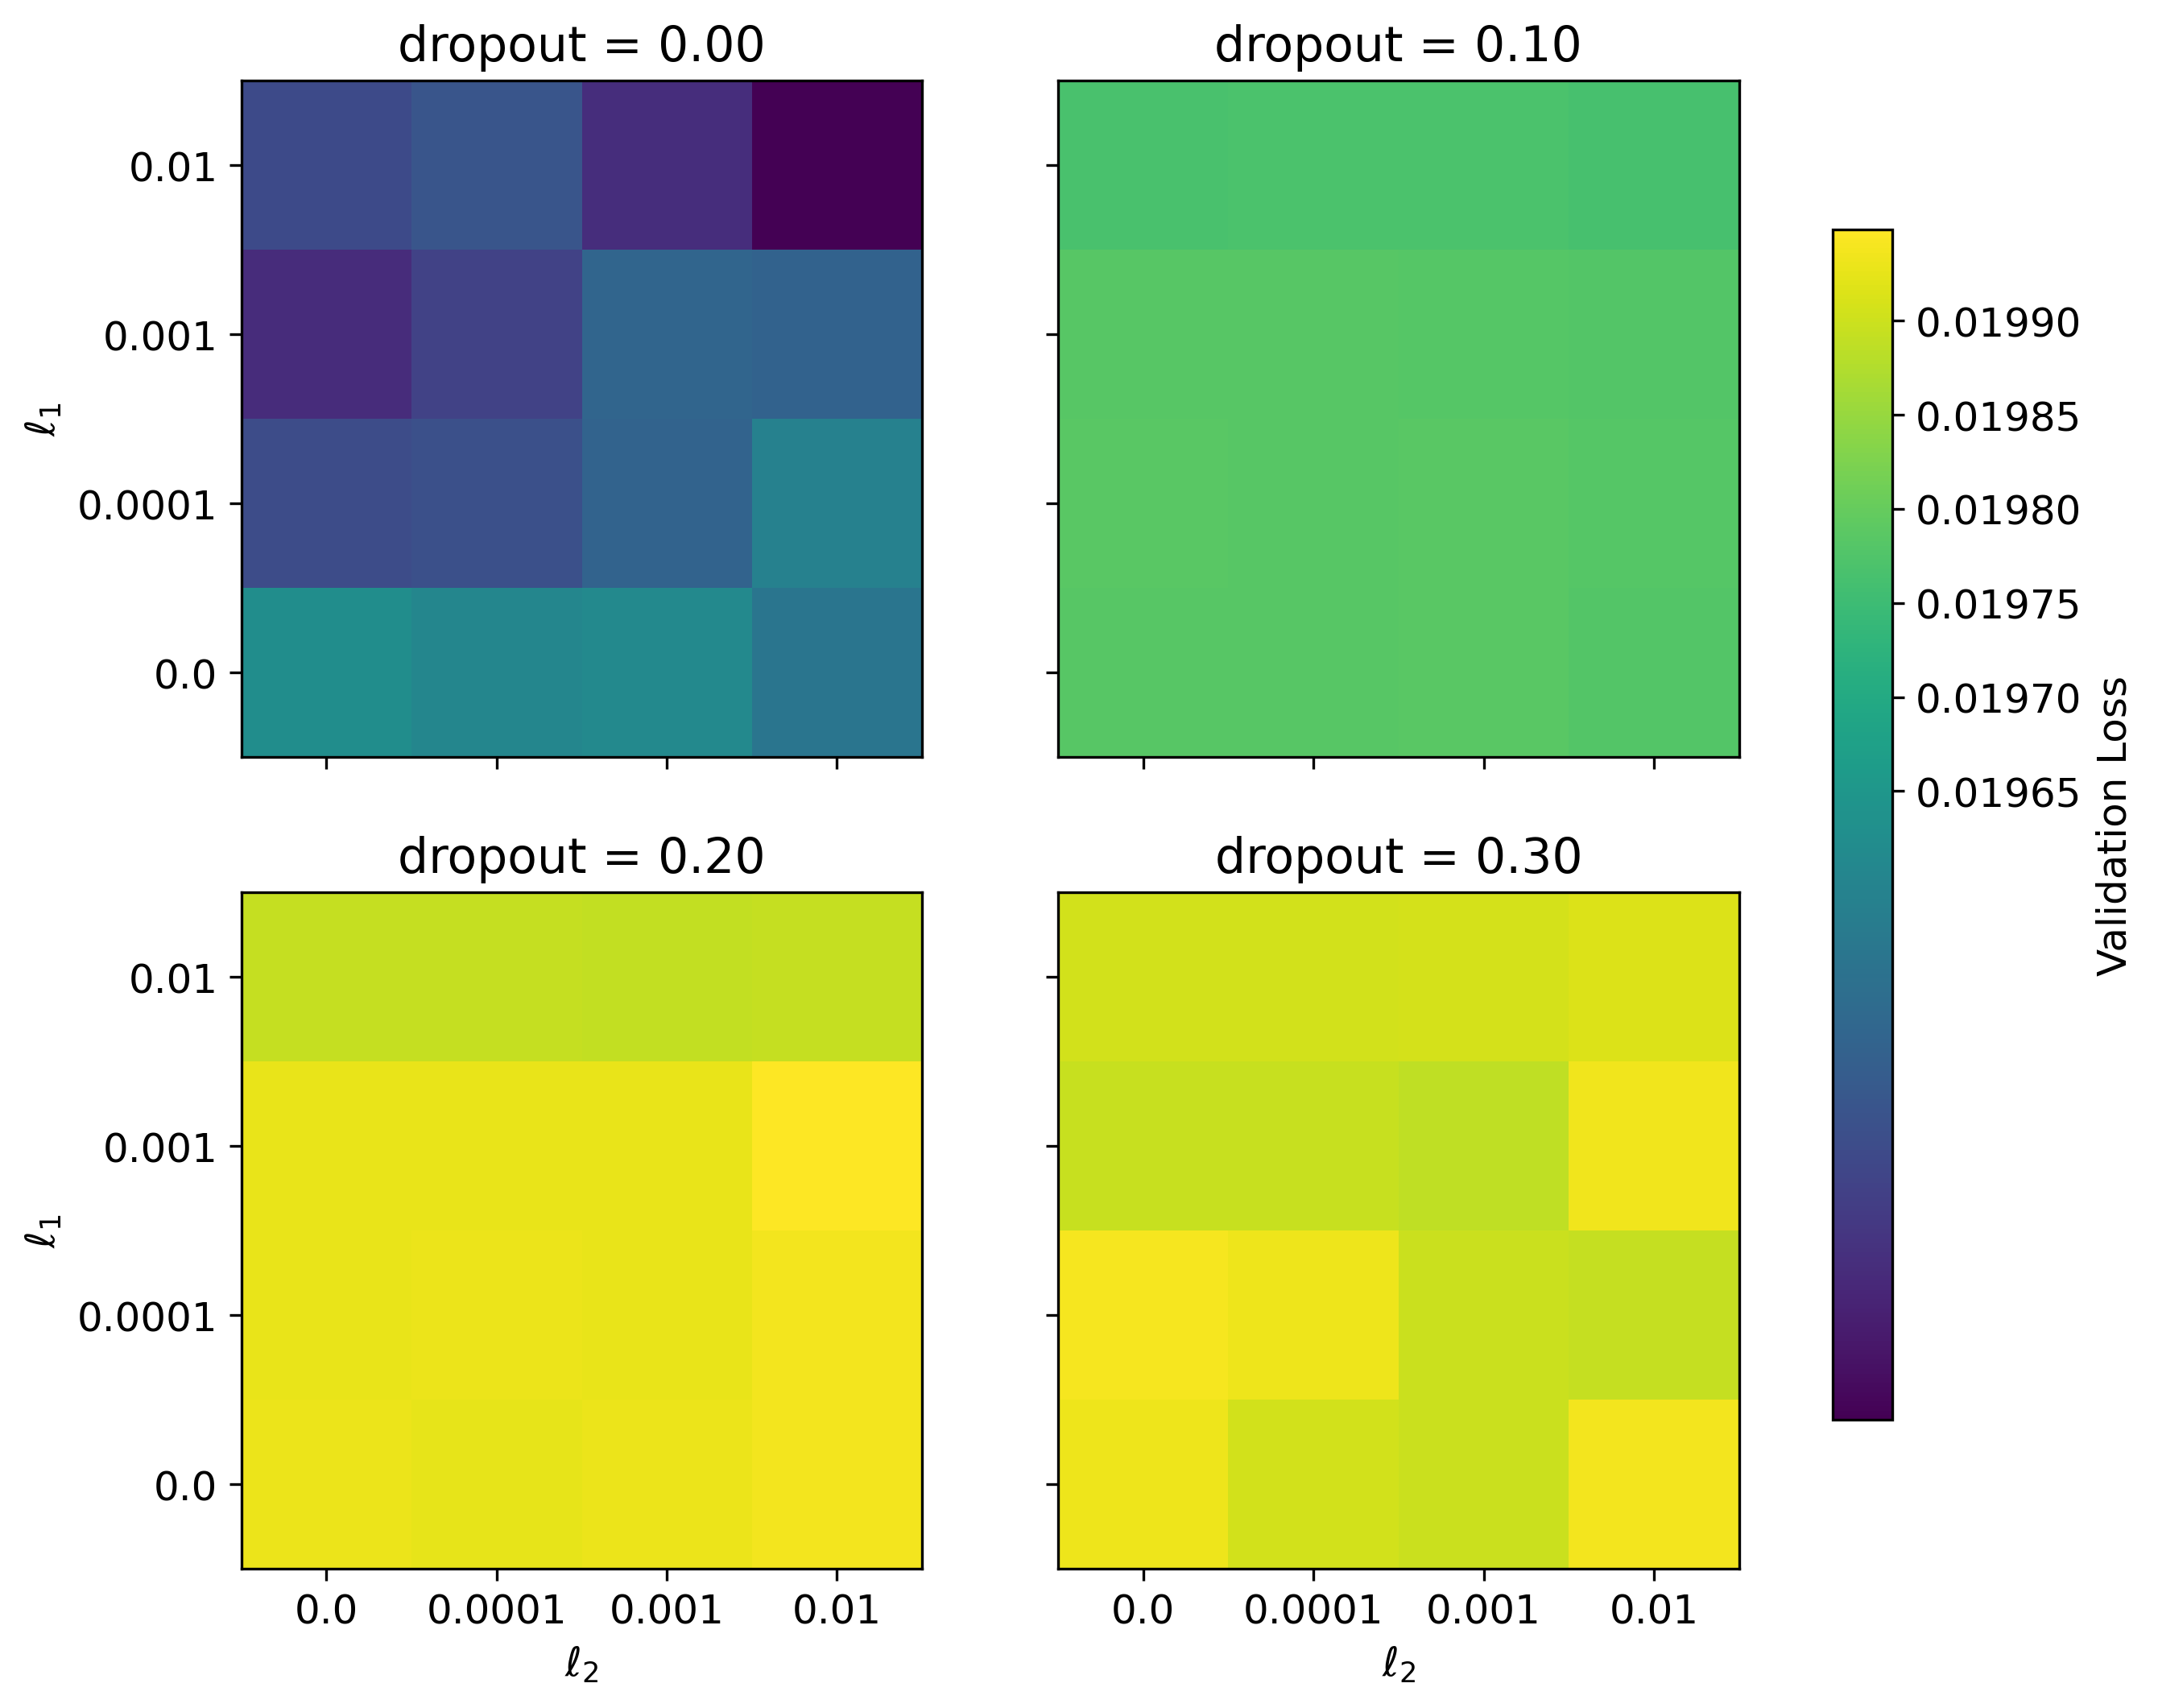

In [84]:
n_l1   = len(l1_space)
n_l2   = len(l2_space)
n_drop = len(dropout_space)

# 1) Build (n_drop, n_l1, n_l2) mean‐loss array (same as before)
losses = np.zeros((n_drop, n_l1, n_l2))
for di, dropout in enumerate(dropout_space):
    for i, lambda_l1 in enumerate(l1_space):
        for j, lambda_l2 in enumerate(l2_space):
            tmp = []
            for hidden_depth in depth_space:
                for hidden_width in width_space:
                    name = (
                        f"l1{lambda_l1}_l2{lambda_l2}"
                        f"_drop{dropout}_lr{learning_rate_space[0]}"
                        f"_w{hidden_width}_d{hidden_depth}"
                    )
                    model = best_models_reg[name]
                    model.eval()
                    batch_losses = []
                    with torch.no_grad():
                        for Xb, yb in val_loader:
                            Xb, yb = Xb.to(device), yb.to(device)
                            yp     = model(Xb)
                            batch_losses.append(criterion(yp, yb).item())
                    tmp.append(np.mean(batch_losses))
            losses[di, i, j] = np.mean(tmp)

# 2) global color‐scale
vmin    = losses.min()
vmax    = losses.max()
vcenter = vmin + 0.05*(vmax - vmin)
norm    = TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)
cmap    = 'viridis'

# 3) layout: at most 3 columns
ncols = min(2, n_drop)
nrows = math.ceil(n_drop / ncols)

fig, axes = plt.subplots(nrows, ncols,
                         figsize=(5*ncols, 4*nrows),
                         squeeze=False)
axes_flat = axes.flatten()

for idx, dropout in enumerate(dropout_space):
    ax = axes_flat[idx]
    im = ax.imshow(
        losses[idx],
        aspect='auto',
        cmap=cmap,
        norm=norm,
        origin='lower'
    )

    # set yticks = ℓ₁, always
    ax.set_yticks(np.arange(n_l1))
    ax.set_yticklabels(l1_space)

    # set xticks = ℓ₂, but we'll hide them on the first row
    ax.set_xticks(np.arange(n_l2))
    ax.set_xticklabels(l2_space)

    # hide x‐labels & ticks for first‐row subplots
    if idx < ncols:
        ax.tick_params(labelbottom=False)
    else:
        ax.set_xlabel(r'$\ell_2$')

    # only first‐column subplots show y‐label
    if idx % ncols == 0:
        ax.set_ylabel(r'$\ell_1$')
    else:
        ax.tick_params(labelleft=False)

    ax.set_title(f"dropout = {dropout:.2f}")

# remove any unused axes
for ax in axes_flat[n_drop:]:
    fig.delaxes(ax)

# single shared colorbar
cbar = fig.colorbar(im, ax=axes_flat[:n_drop].tolist(), shrink=0.8)
cbar.set_label('Validation Loss')

# plt.tight_layout()
plt.show()
